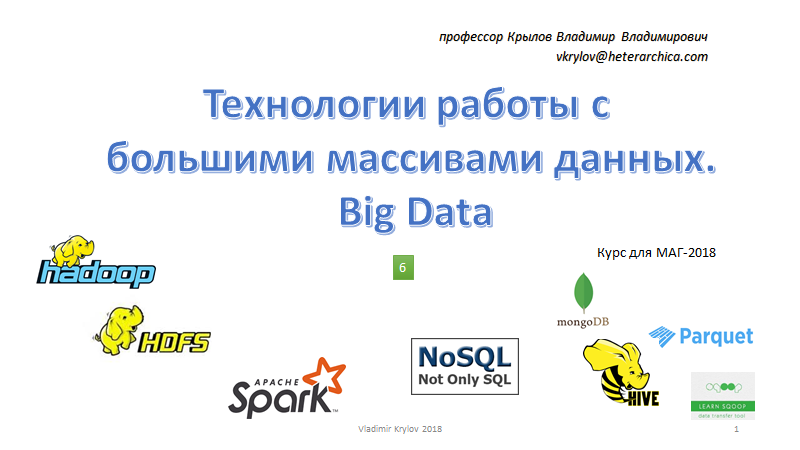

# GraphX  продолжение

In [1]:
!pip install pyspark

In [2]:
import pyspark
import random

In [3]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
import time
import pandas as pd
from pyspark.sql import SparkSession
import pandas as pd

conf = SparkConf()

conf.set('spark.jars.packages','graphframes:graphframes:0.3.0-spark2.0-s_2.11')

In [4]:
print(conf.toDebugString())

spark.jars.packages=graphframes:graphframes:0.3.0-spark2.0-s_2.11


In [5]:
from pyspark.sql import *
from pyspark.sql.functions import udf

In [6]:
conf.setAppName('TheSecondTestingApp')
#conf.setMaster('spark://dell-inspiron:7077') # if master is started using command line
conf.setMaster('local[*]')
from pyspark import SparkContext
sc=SparkContext.getOrCreate(conf=conf) #Start the spark context
spark = SparkSession.builder.appName('notebook').getOrCreate()

In [7]:
!pip install graphframes

In [8]:
from graphframes import *

In [9]:
vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50), 
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])
edges = spark.createDataFrame([('1', '2', 'friend'), 
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])

In [10]:
g = GraphFrame(vertices, edges)

In [11]:
## Take a look at the DataFrames
g.vertices.show()
g.edges.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+



In [12]:
## Check the number of edges of each vertex
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  3|     7|
| 98|     2|
| 99|     2|
|  5|     3|
|  1|     4|
|  4|     3|
|  2|     3|
+---+------+



The GraphFrame we just created is a directed one, and can be visualized as follows:
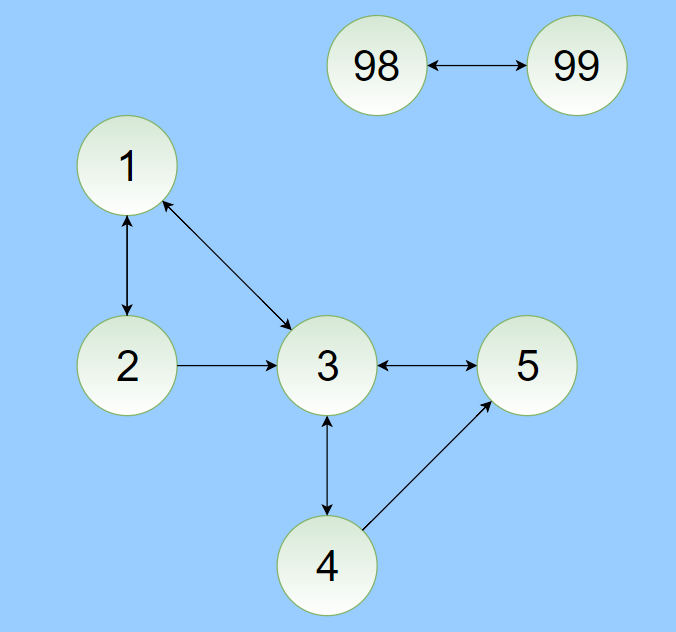

In [13]:
copy = edges

@udf("string")
def to_undir(src, dst):
    if src >= dst:
        return 'Delete'
    else : 
        return 'Keep'
copy.withColumn('undir', to_undir(copy.src, copy.dst))\
.filter('undir == "Keep"').drop('undir').show()
## for efficiency, it's better to avoid udf functions where possible ## and use built-in pyspark.sql.functions instead.

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
+---+---+-------+



### Filtering and connected components

In [14]:
g.vertices.filter("age > 30").show()
g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()
g.edges.filter('type == "friend"')

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
+---+------+---------+---+

+---+--------+
| id|inDegree|
+---+--------+
|  3|       4|
|  1|       2|
|  5|       2|
+---+--------+



DataFrame[src: string, dst: string, type: string]

In [15]:
sc.setCheckpointDir('graphframes_cps')

In [17]:
# g.connectedComponents().show()

### Motif finding

In [18]:
g.find("(a)-[e]->(b); (b)-[e2]->(a)").show()

+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
| [98, Berg, Tim, 28]|[98, 99, friend]|[99, Page, Allan,...|[99, 98, friend]|
|[2, May, Derrick,...|  [2, 1, friend]|[1, Carter, Derri...|  [1, 2, friend]|
|[99, Page, Allan,...|[99, 98, friend]| [98, Berg, Tim, 28]|[98, 99, friend]|
|[3, Mills, Jeff, 80]|  [3, 5, friend]|[5, Banks, Mike, 93]|  [5, 3, friend]|
|[1, Carter, Derri...|  [1, 3, friend]|[3, Mills, Jeff, 80]|  [3, 1, friend]|
|[3, Mills, Jeff, 80]|  [3, 1, friend]|[1, Carter, Derri...|  [1, 3, friend]|
|[5, Banks, Mike, 93]|  [5, 3, friend]|[3, Mills, Jeff, 80]|  [3, 5, friend]|
|[4, Hood, Robert,...|  [4, 3, friend]|[3, Mills, Jeff, 80]|  [3, 4, friend]|
|[1, Carter, Derri...|  [1, 2, friend]|[2, May, Derrick,...|  [2, 1, friend]|
|[3, Mills, Jeff, 80]|  [3, 4, friend]|[4, Hood, Robert,...|  [4

In [19]:
mutualFriends=g.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(b); (b)-[]->(a)")\
.dropDuplicates()

In [20]:
mutualFriends.filter('a.id == 2 and c.id == 3').show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|[2, May, Derrick,...|[1, Carter, Derri...|[3, Mills, Jeff, 80]|
+--------------------+--------------------+--------------------+



### TriangleCount 

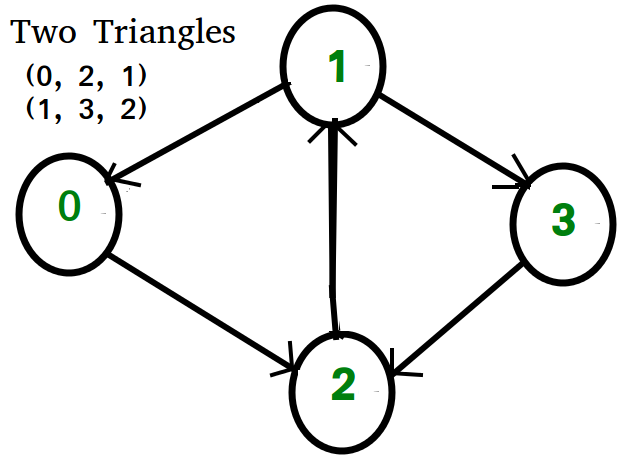

In [21]:
g.triangleCount().show()

+-----+---+------+---------+---+
|count| id|  name|firstname|age|
+-----+---+------+---------+---+
|    2|  3| Mills|     Jeff| 80|
|    0| 98|  Berg|      Tim| 28|
|    0| 99|  Page|    Allan| 16|
|    1|  5| Banks|     Mike| 93|
|    1|  1|Carter|  Derrick| 50|
|    1|  4|  Hood|   Robert| 65|
|    1|  2|   May|  Derrick| 26|
+-----+---+------+---------+---+

